In [108]:
# joining in R with fuzzy match gave better results, therefore we import that table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
import numpy as np
from scipy import stats 
# Path to your Excel file
file_path = 'joined_data.xlsx'

# Read the specific sheet from the Excel file
sheet_name = 'All best match'

# Read the data from the Excel file
df = pd.read_excel(file_path, sheet_name=sheet_name)

#we take the values that are included in the analysis
df=df[df['included']==1]
df=df[df['completed']==1]



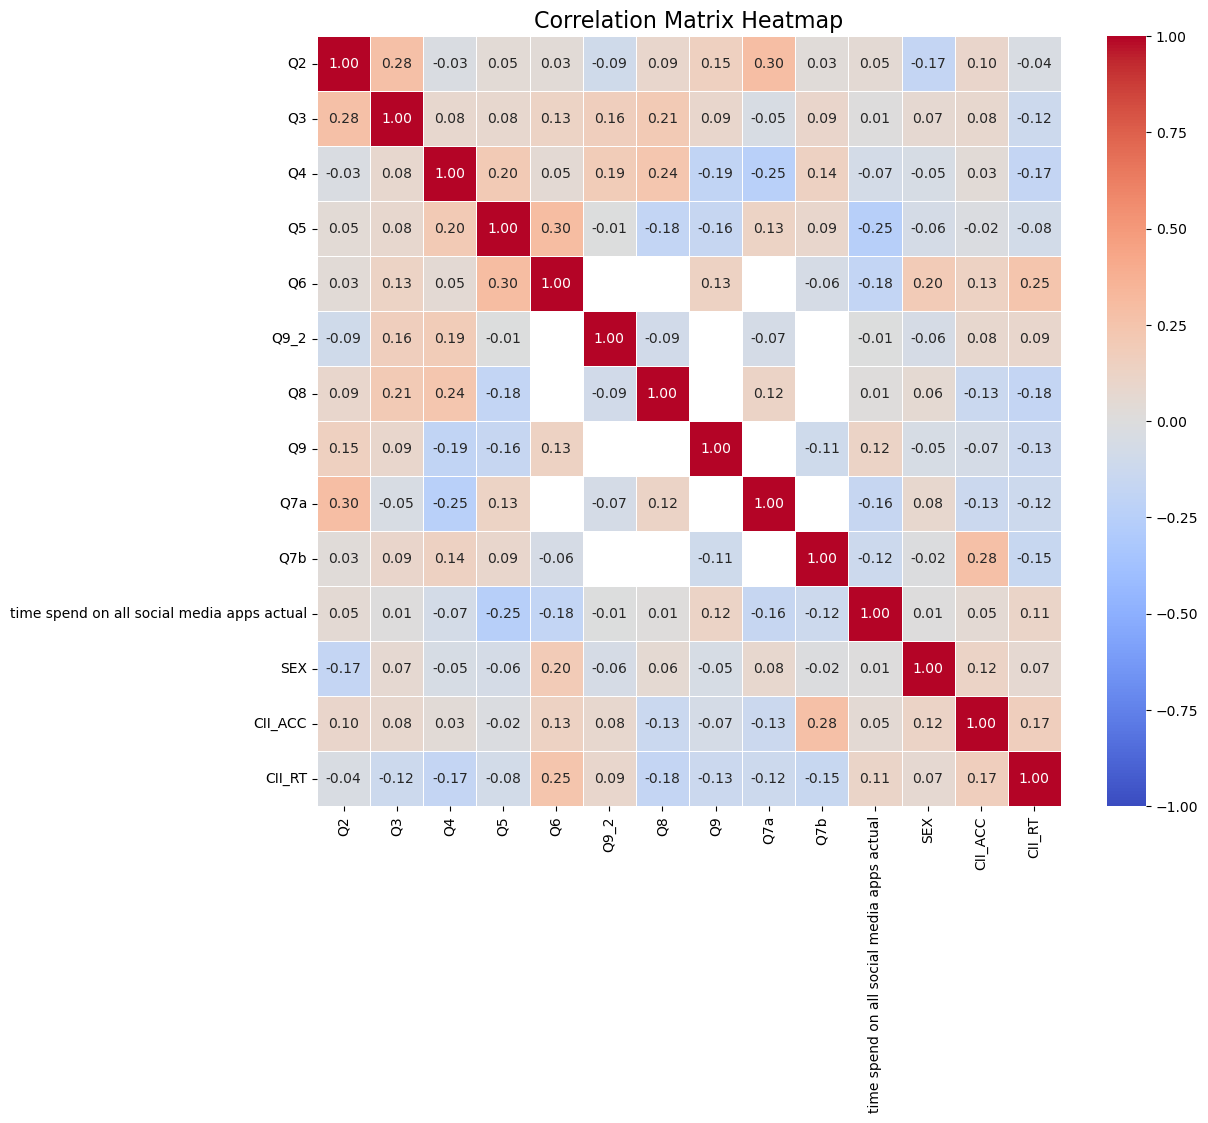

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation = df[['Q2','Q3','Q4','Q5','Q6','Q9_2','Q8','Q9','Q7a','Q7b' ,'time spend on all social media apps actual','SEX','CII_ACC', 'CII_RT']].corr()
correlation

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with the correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Set plot title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

In [109]:
#correaltion analysis for instagram and tiktok
from scipy.stats import ttest_ind, pearsonr
actual_cols = ['Instagram actual','TikTok actual']
df['avg_actual'] = df[actual_cols].mean(axis=1, skipna=True)
flanker_cols = df.columns[11:13]
# Correlation analysis
print("\nCorrelation between Social Media Usage and Flanker Task Performance:")
for col in flanker_cols:
    corr, _ = pearsonr(df['avg_actual'].dropna(), df[col].dropna())
    print(f"Correlation between avg_actual and {col}: {corr}")


# Hypothesis testing
high_usage = df[df['avg_actual'] > df['avg_actual'].median()]
low_usage = df[df['avg_actual'] <= df['avg_actual'].median()]

print("\nT-test for differences in Flanker Task Performance between High and Low Social Media Usage:")
for col in flanker_cols:
    t_stat, p_val = ttest_ind(high_usage[col].dropna(), low_usage[col].dropna(), equal_var=False)
    print(f"T-test for {col}: t-stat={t_stat}, p-value={p_val}")





Correlation between Social Media Usage and Flanker Task Performance:
Correlation between avg_actual and CII_ACC: 0.1005834264005397
Correlation between avg_actual and CII_RT: -0.005183911290169958

T-test for differences in Flanker Task Performance between High and Low Social Media Usage:
T-test for CII_ACC: t-stat=0.3607786893380329, p-value=0.7193845976188505
T-test for CII_RT: t-stat=-0.04718969920649684, p-value=0.9624691633986834


The correlations between social media usage and Flanker task performance (both accuracy and reaction time) are very weak, indicating a slight relationship, but not strong enough to be meaningful.

The t-tests show no significant differences in Flanker task performance between participants with high and low social media usage. This suggests that social media usage does not have a substantial impact on the accuracy or reaction times in the Flanker task among the participants in the study.

In [110]:
# Correlation analysis for all social media
print("\nCorrelation between Social Media Usage and Flanker Task Performance:")
for col in flanker_cols:
    corr, _ = pearsonr(df['time spend on all social media apps actual'].dropna(), df[col].dropna())
    print(f"Correlation between avg_actual and {col}: {corr}")


# Hypothesis testing
high_usage = df[df['time spend on all social media apps actual'] > df['time spend on all social media apps actual'].median()]
low_usage = df[df['time spend on all social media apps actual'] <= df['time spend on all social media apps actual'].median()]

print("\nT-test for differences in Flanker Task Performance between High and Low Social Media Usage:")
for col in flanker_cols:
    t_stat, p_val = ttest_ind(high_usage[col].dropna(), low_usage[col].dropna(), equal_var=False)
    print(f"T-test for {col}: t-stat={t_stat}, p-value={p_val}")


Correlation between Social Media Usage and Flanker Task Performance:
Correlation between avg_actual and CII_ACC: 0.049527065341983374
Correlation between avg_actual and CII_RT: 0.11273146634624669

T-test for differences in Flanker Task Performance between High and Low Social Media Usage:
T-test for CII_ACC: t-stat=0.3676638720164163, p-value=0.7140290085067524
T-test for CII_RT: t-stat=0.8357164745646202, p-value=0.4055574888894973


In [113]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Linear regression example for flanker task score (CII_RT as dependent variable) and all social media
X = df[['time spend on all social media apps actual','SEX','AGE']]
y = df['CII_RT']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CII_RT   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.5268
Date:                Fri, 02 Aug 2024   Prob (F-statistic):              0.665
Time:                        17:58:53   Log-Likelihood:                 113.52
No. Observations:                  91   AIC:                            -219.0
Df Residuals:                      87   BIC:                            -209.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [114]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
median_usage = df['time spend on all social media apps actual'].median(skipna=True)

# Create the new column `social_media_group` based on the median value
df['social_media_group'] = np.where(
    df['time spend on all social media apps actual'] > median_usage,
    'high',
    'low'
)
# Convert categorical variable to dummy/indicator variables
df_dummies = pd.get_dummies(df[['social_media_group', 'SEX', 'AGE']], drop_first=True)

# Define predictors and response variable
X = df_dummies
X = sm.add_constant(X)  # Add constant term for the intercept
y = df['CII_RT']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [115]:
# Linear regression example for flanker task score (CII_RT as dependent variable) and instagram and tiktok
X = df[['Instagram actual','TikTok actual','SEX','AGE']]
y = df['CII_RT']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CII_RT   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.1676
Date:                Fri, 02 Aug 2024   Prob (F-statistic):              0.954
Time:                        17:59:33   Log-Likelihood:                 113.06
No. Observations:                  91   AIC:                            -216.1
Df Residuals:                      86   BIC:                            -203.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8520      0.142  

In [116]:
# Logistic regression example for a binary risk-taking outcome
lotteries = ['Q2','Q3','Q4','Q5']
for column in lotteries:
    X = df[['Instagram actual','TikTok actual','SEX','AGE','CII_RT']]
    y = df[column]
    X = sm.add_constant(X)
    logit_model = sm.Logit(y, X).fit()
    print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.464701
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     Q2   No. Observations:                   91
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                            5
Date:                Fri, 02 Aug 2024   Pseudo R-squ.:                 0.06563
Time:                        18:00:04   Log-Likelihood:                -42.288
converged:                       True   LL-Null:                       -45.258
Covariance Type:            nonrobust   LLR p-value:                    0.3121
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.1372      6.296      0.657      0.511      -8.202      16.476
Instagram a

In [93]:
lotteries = ['Q2','Q3','Q4','Q5']
# Correlation analysis for all social media and lotteries
print("\nCorrelation between Social Media Usage and Risk-taking tasks")
for col in lotteries:
    corr, _ = pearsonr(df['time spend on all social media apps actual'].dropna(), df[col].dropna())
    print(f"Correlation between avg_actual and {col}: {corr}")

lotteries = ['Q2','Q3','Q4','Q5','Q6','Q9_2','Q8','Q9','Q7a','Q7b']
# Hypothesis testing
high_usage = df[df['time spend on all social media apps actual'] > df['time spend on all social media apps actual'].median()]
low_usage = df[df['time spend on all social media apps actual'] <= df['time spend on all social media apps actual'].median()]

print("\nT-test for differences in Risk-taking tasks between High and Low Social Media Usage:")
for col in lotteries:
    t_stat, p_val = ttest_ind(high_usage[col].dropna(), low_usage[col].dropna(), equal_var=False)
    print(f"T-test for {col}: t-stat={t_stat}, p-value={p_val}")


Correlation between Social Media Usage and Risk-taking tasks
Correlation between avg_actual and Q2: 0.04689117937515105
Correlation between avg_actual and Q3: 0.006914562734548986
Correlation between avg_actual and Q4: -0.07131579881091032
Correlation between avg_actual and Q5: -0.252776873077521

T-test for differences in Risk-taking tasks between High and Low Social Media Usage:
T-test for Q2: t-stat=0.05147779972113347, p-value=0.9590602628895609
T-test for Q3: t-stat=0.047881955431471744, p-value=0.9619177090454947
T-test for Q4: t-stat=-0.051477799721133144, p-value=0.9590602628895611
T-test for Q5: t-stat=-1.4891918592347604, p-value=0.1401033584116102
T-test for Q6: t-stat=-1.7542513169065332, p-value=0.08722001144575153
T-test for Q9_2: t-stat=0.22716728680453313, p-value=0.8214603469437299
T-test for Q8: t-stat=0.12163442038338085, p-value=0.9038106056448911
T-test for Q9: t-stat=-0.05761033944889726, p-value=0.9543280400248817
T-test for Q7a: t-stat=-0.30078881455629775, p-v

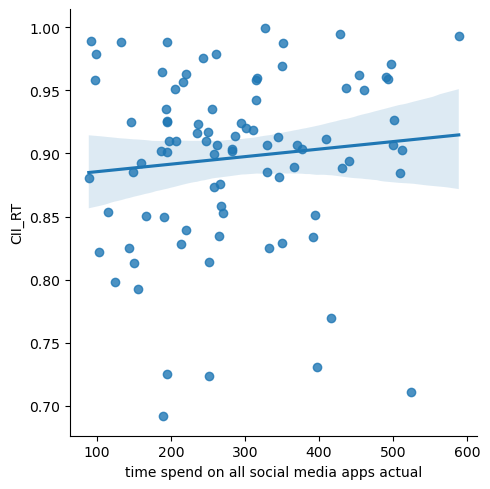

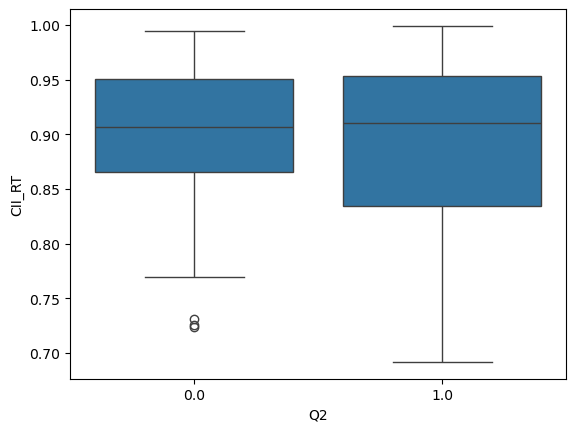

In [83]:
# Visualization
sns.lmplot(x='time spend on all social media apps actual', y='CII_RT', data=df)
plt.show()

sns.boxplot(x='Q2', y='CII_RT', data=df)
plt.show()

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Example for binary outcome
X = df[['CII_ACC','CII_RT','SEX','AGE']]
y = df['Q2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5925925925925926
              precision    recall  f1-score   support

         0.0       0.67      0.84      0.74        19
         1.0       0.00      0.00      0.00         8

    accuracy                           0.59        27
   macro avg       0.33      0.42      0.37        27
weighted avg       0.47      0.59      0.52        27



In [95]:
# transforming risk taking outcomes into just one variable for lotteries, to see if we find some siginifcant resutls
# Create a risk-taking variable
def classify_risk_taking(row):
    num_risky = sum(row[col] == 1 for col in lotteries)
    num_safe = sum(row[col] == 0 for col in lotteries)
    if num_risky > num_safe:
        return 1  # Risk-taking
    elif num_safe > num_risky:
        return 2   # Risk-averse
    else:
        return 0   # Neutral

df['risk_taking'] = df.apply(classify_risk_taking, axis=1)
# Risk-taking framing  from scenarios
scenarios_columns = ['Q8', 'Q9', 'Q7a', 'Q7b']
def classify_framing(row):
    num_risky = sum(row[col] == 1 for col in scenarios_columns)
    num_safe = sum(row[col] == 0 for col in scenarios_columns)
    if num_risky == 2:
        return 0  
    elif num_safe == 2:
        return 0   
    else:
        return 1   
    
    
df['framing'] = df.apply(classify_framing, axis=1)
sum(df['framing'])

54

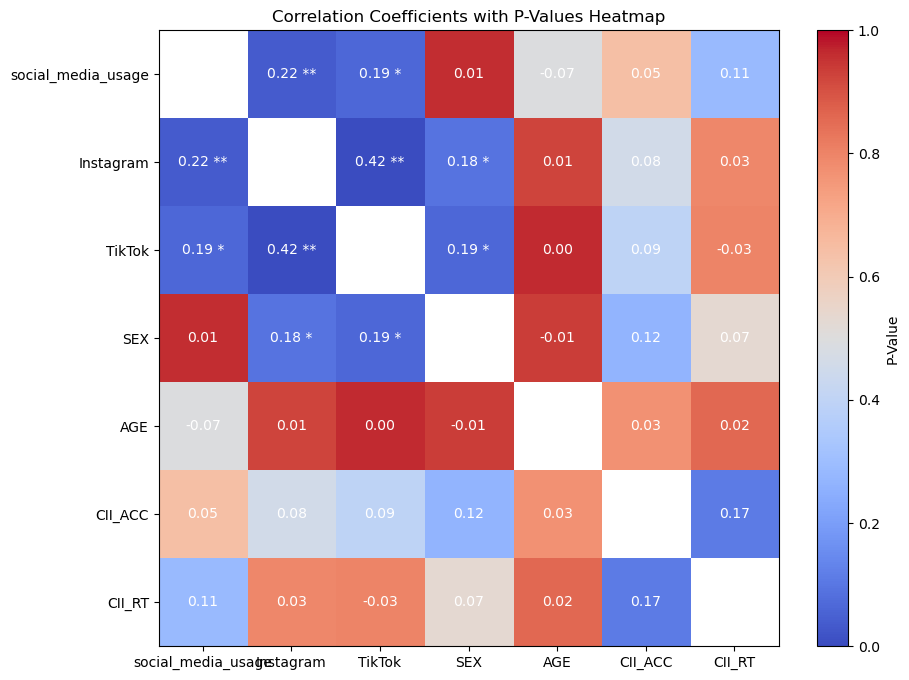

In [106]:
#survey.rename(columns={'time spend on all social media apps actual': 'social_media_usage','Instagram actual':'Instagram','TikTok actual':'TikTok'}, inplace=True)
df.rename(columns={'time spend on all social media apps actual': 'social_media_usage','Instagram actual':'Instagram','TikTok actual':'TikTok'}, inplace=True)
columns = ['social_media_usage','Instagram','TikTok' ,'SEX','AGE','CII_ACC','CII_RT']
n = len(columns)

# Create matrices to store correlation coefficients and p-values
correlation_matrix = np.zeros((n, n))
p_value_matrix = np.zeros((n, n))

# Calculate correlation coefficients and p-values
for i in range(n):
    for j in range(n):
        if i == j:
            correlation_matrix[i, j] = np.nan
            p_value_matrix[i, j] = np.nan
        else:
            corr, p_value = pearsonr(df[columns[i]], df[columns[j]])
            correlation_matrix[i, j] = corr
            p_value_matrix[i, j] = p_value

# Create a combined DataFrame for plotting
combined_df = pd.DataFrame({
    'Correlation': correlation_matrix.flatten(),
    'P-Value': p_value_matrix.flatten(),
    'Row': np.repeat(range(n), n),
    'Col': np.tile(range(n), n)
})

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a color map for p-values
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=0, vmax=1)

# Create the heatmap
heatmap = ax.imshow(p_value_matrix, cmap=cmap, norm=norm, aspect='auto')

# Annotate with correlation coefficients and significance stars
for i in range(n):
    for j in range(n):
        if not np.isnan(correlation_matrix[i, j]):
            value = correlation_matrix[i, j]
            p_value = p_value_matrix[i, j]
            annotation = f'{value:.2f}'
            if p_value < 0.05:
                annotation += ' **'
            elif p_value < 0.1:
                annotation += ' *'
            ax.text(j, i, annotation,
                    ha='center', va='center', color='white')

# Add color bar and labels
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical')
cbar.set_label('P-Value')

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)
ax.set_title('Correlation Coefficients with P-Values Heatmap')

plt.show()